# Atividade Aula 35 (24/09/2025)
### Regressão logística com pinguins  

### Importação de bibliotecas

In [1]:
# Importação das bibliotecas necessárias para a análise.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Importar base de dados

### Carregamento dos dados

In [2]:
# Carregando o conjunto de dados de pinguins para análise.
penguin_url = "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv"
df = pd.read_csv(penguin_url)
df.dropna(inplace=True)

species_map = {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 0}
y = df['species'].map(species_map).values

feature_cols = ['bill_length_mm', 'bill_depth_mm']
X_o = df[feature_cols].values

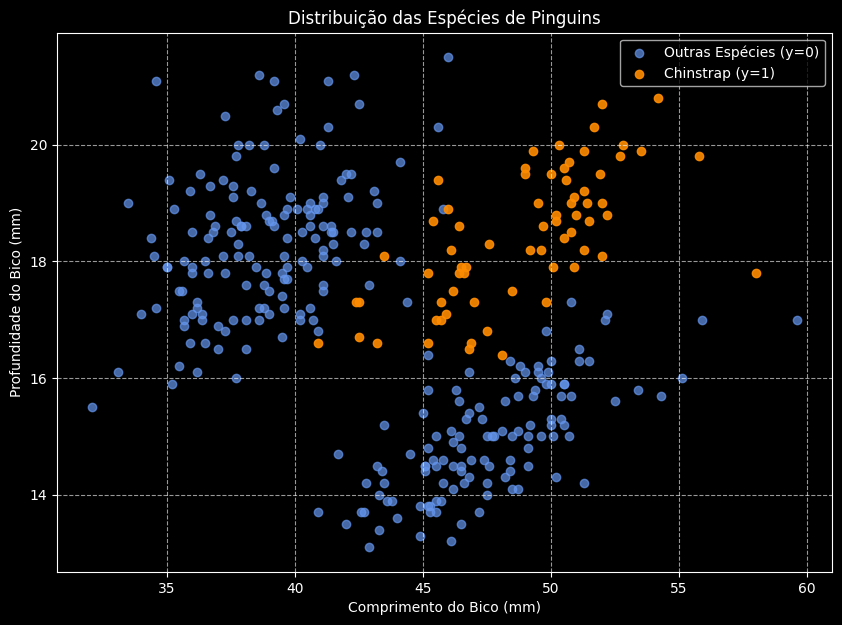

In [3]:
# Execução de etapa intermediária do processo.
chinstrap = (y == 1)
outros = (y == 0)

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(X_o[outros, 0], X_o[outros, 1],
           c='cornflowerblue', label='Outras Espécies (y=0)', alpha=0.7)
ax.scatter(X_o[chinstrap, 0], X_o[chinstrap, 1],
           c='darkorange', label='Chinstrap (y=1)', alpha=0.9)

ax.set_xlabel('Comprimento do Bico (mm)')
ax.set_ylabel('Profundidade do Bico (mm)')
ax.set_title('Distribuição das Espécies de Pinguins')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [4]:
# Execução de etapa intermediária do processo.
def designmatrix(X, grau):
  X = np.asarray(X, float)
  x1 = X[:,0:1]
  x2 = X[:, 1:1+1]
  cols = [np.ones((X.shape[0],1))]
  for i in range(grau+1):
    for j in range(grau+1-i):
      if i==0 and j==0:
        continue
      cols.append(x1**i * x2**j)
  return np.hstack(cols)

In [5]:
# Execução de etapa intermediária do processo.
def standardize_train(X): # padronização das variaveis (exceto a constante)
  X = np.asarray(X, float)
  Xs = X.copy()
  mu = X[:,1:].mean(axis=0)
  sd = X[:,1:].std(axis=0, ddof = 0)
  sd = np.where(sd==0, 1, sd)
  Xs[:,1:] = (X[:,1:] - mu)/sd
  return Xs, mu, sd

def standardize_apply(X, mu, sd): # a padronização calculada no treino deve ser aplicada ao conjunto de teste
  Xs = X.copy()
  Xs[:,1:] = (X[:,1:]-mu)/sd
  return Xs

def sigmoid(z):
  return 1.0/(1.0 +np.exp(-z))

def logloss_and_grad(w, X, y, lam):
  # z= w0 + w1*x1 + w2*x2  # w= [w0; w1; w2]
  z = X @ w

  # calcular a logloss (custo)
  loss = np.sum(np.logaddexp(0,z) - y*z)  # y = [0; 1; 0;0;0;0;1;1;0; ... 1]
                                          # z = [2 ; 3; 4 ]
  #print(loss)
  # adiciona a regularização L2 ao custo
  loss += lam*np.sum(w[1:]**2)

  # calcula as probabilidades previstas
  p= sigmoid(z)

  # Calcula o gradiente
  grad = X.T @ (p-y) # dimensão de grad é igual a de w

  # adiciona o termo de gradiente da regularização L2 (lembrando que não é aplicado a primeira coluna aqui)
  grad[1:] += 2*lam*w[1:]

  return loss/len(y), grad/len(y)

def ajustelogistico(X, y, lam=1e-2, ta=0.1, iters=2000, tol = 1e-7):
  historico_w = []
  w= np.zeros(X.shape[1])
  historico_w.append(w.copy())
  prev_loss = np.inf
  for t in range(iters):
    loss, grad = logloss_and_grad(w, X, y, lam)
    w -= ta*grad
    historico_w.append(w.copy())
    if abs(prev_loss - loss) < tol:
      break
    prev_loss = loss
  return w, np.array(historico_w)

def kfolds_idx(y, k=5, seed=42, shuffle=True):
  y = np.asarray(y, int)

  idx0= np.where(y==0)[0]
  idx1= np.where(y==1)[0]

  rng = np.random.default_rng(seed)
  rng.shuffle(idx0)
  rng.shuffle(idx1)

  folds0= np.array_split(idx0, k)
  folds1= np.array_split(idx1, k)
  print(len(folds0))
  print(len(folds1))
  folds= [np.concatenate([f0,f1]) for f0, f1 in zip(folds0, folds1)]
  return folds

def cv_grid(X , y , graus, lambdas, k= 5, seed =42, ta=0.1, iters=2000):
  s = kfolds_idx(y, k, seed)
  results=[]
  for d in graus:
    for lam in lambdas:
      custos = []
      for f in range(k):
        va=s[f]
        tr= np.concatenate([s[i] for i in range(k) if i!=f])

        Xtr = designmatrix(X[tr], d)
        Xva = designmatrix(X[va], d)
        ytr = y[tr]
        yva = y[va]

        Xtr_p, mi, std = standardize_train(Xtr)
        Xva_p = standardize_apply(Xva, mi, std)

        w, _ = ajustelogistico(Xtr_p, ytr, lam, ta, iters)


        z = Xva_p @ w
        ll = np.mean(np.logaddexp(0,z)- yva*z)
        custos.append(ll)



      results.append(( float(np.mean(custos)),d , float(lam)))
  best = min(results, key= lambda x: x[0])
  return results, best

In [6]:
# Execução de etapa intermediária do processo.
graus = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
lambdas = [0 , 0.000001]

resultado, melhor= cv_grid(X_o, y,graus, lambdas)
print(melhor)

5
5
(0.14596723406569043, 8, 0.0)


In [7]:
# Execução de etapa intermediária do processo.
mtz_reg= designmatrix(X_o,8)

In [8]:
# Execução de etapa intermediária do processo.
def traintestsplit(X, y, test_size=0.20, seed=7):
  rng = np.random.default_rng(7)
  n= len(y)
  idx0 = np.where(y==0)[0]    # indices dos pontos em que y==0
  idx1 = np.where(y==1)[0]    # indices dos pontos em que y==1
  rng.shuffle(idx0)       # embaralha os arrays contendo os indices
  rng.shuffle(idx1)
  n0_te = int(round(test_size* len(idx0))) # numero de elementos de classe zero que o conjunto de teste deve conter
  n1_te = int(round(test_size* len(idx1))) # numero de elementos de classe um que o conjunto de teste deve conter

  # aqui juntamos o array de indices do conjunto de teste de classes zero e um
  te_idx = np.concatenate((idx0[:n0_te], idx1[:n1_te])) # indices do conjunto de teste
  # o array formado pela concatenação de idx0[de 0 até n0_te-1] e idx1[de 0 até n0_te-1] é o array de teste completo

  # Os indices restantes são correspondem aos pontos que serão usado para treinamento
  tr_idx = np.concatenate((idx0[n0_te:], idx1[n1_te:])) # indices do conjunto de treino


  rng.shuffle(te_idx) # faz um embaralhamento final dos indices do array de treinamento e teste
  rng.shuffle(tr_idx)

  return X[tr_idx], X[te_idx], y[tr_idx], y[te_idx]

In [9]:
# Execução de etapa intermediária do processo.
X_tr, X_tst,y_tr, y_tst= traintestsplit(X_o, y)

In [10]:
# Execução de etapa intermediária do processo.
mtz_trn = designmatrix(X_tr,8)
Xp, mu, sd= standardize_train(mtz_trn)
w, hist= ajustelogistico(Xp, y_tr)

print(w)


[-2.82503112e+00  2.77444495e-01  6.81764990e-03 -2.73720096e-01
 -5.56818904e-01 -8.35354990e-01 -1.10286677e+00 -1.35388744e+00
 -1.58415018e+00 -7.55912581e-02  6.30375428e-01  5.92429133e-01
  3.54260847e-01  7.33690520e-02 -2.17154487e-01 -5.04780029e-01
 -7.81928226e-01 -2.82645841e-01  4.30575604e-01  7.50232014e-01
  7.48260787e-01  5.88687025e-01  3.58654046e-01  9.83504509e-02
 -4.90471389e-01  2.08416452e-01  6.76301390e-01  8.78167939e-01
  8.85119007e-01  7.71678567e-01 -6.89895772e-01  2.44387100e-03
  5.36932844e-01  8.64971427e-01  1.00905022e+00 -8.71700560e-01
 -1.83746718e-01  3.85144566e-01  7.89723963e-01 -1.02730512e+00
 -3.45819278e-01  2.40481953e-01 -1.14948043e+00 -4.78980010e-01
 -1.23301016e+00]


In [11]:
# Execução de etapa intermediária do processo.
def plotarlimites(X, y, mu, sd, w, grau):
  x1min, x1max = X[:,0].min()-0.5, X[:,0].max()+0.5
  x2min, x2max = X[:,1].min()-0.5, X[:,1].max()+0.5

  gx1 , gx2 = np.meshgrid(np.linspace(x1min, x1max, 200), np.linspace(x2min, x2max,200))

  Xg = np.c_[gx1.ravel(),gx2.ravel()]
  Xg_design = designmatrix(Xg, grau)
  Xg_design_p = standardize_apply(Xg_design, mu, sd)
  zg = Xg_design_p @ w
  pg = 1.0/ (1.0+ np.exp(-zg)).reshape(gx1.shape)
  plt.figure(figsize=(10,10))
  plt.contour(gx1,gx2, pg, levels= [0.5], linewidths=3)
  plt.contourf(gx1,gx2, pg, level = np.linspace(0,1,11), alpha=0.3)
  plt.scatter(X[:,0], X[:,1], c=y)
  print(pg.max())
  print(pg.min())
  plt.show()

0.9999999817524458
4.661767068943719e-14


C:\Users\84284528572\AppData\Local\Temp\ipykernel_17116\3276894558.py:15: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(gx1,gx2, pg, level = np.linspace(0,1,11), alpha=0.3)


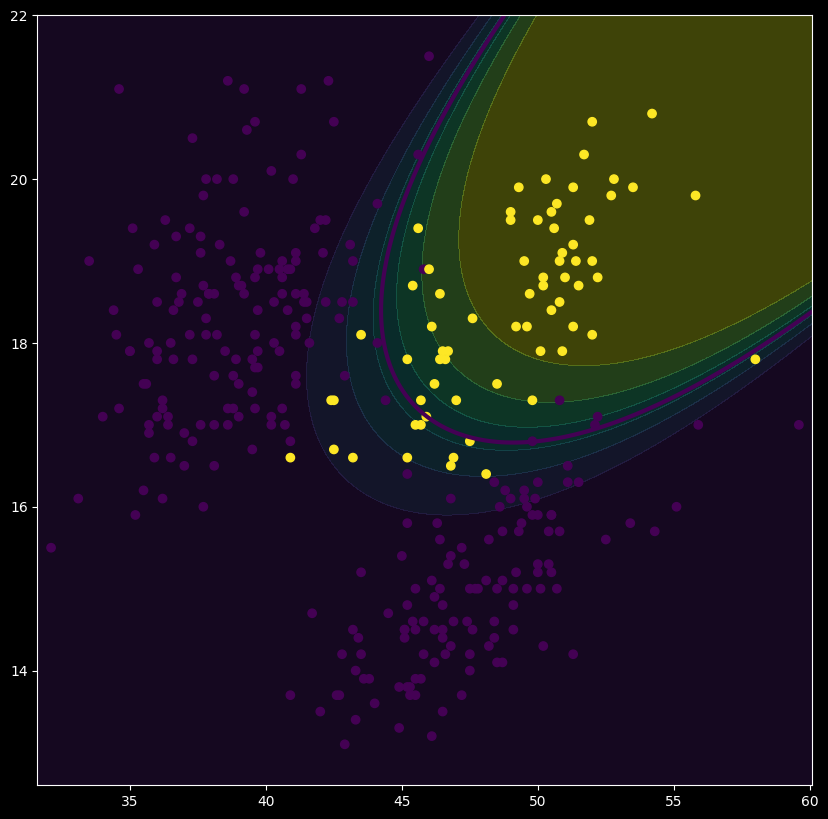

In [12]:
# Execução de etapa intermediária do processo.
plotarlimites(X_o,y,mu, sd,w,8)

Avaliacao do modelo

In [13]:
# Execução de etapa intermediária do processo.
mtrz_tst = designmatrix(X_tst,8)
Xs = standardize_apply(mtrz_tst, mu,sd)

In [14]:
# Execução de etapa intermediária do processo.
def predict_proba(Xs, w):
    return 1.0 / (1.0 + np.exp(-(Xs @ w)))

def confusion(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    tp = int(np.sum((y_true==1) & (y_pred==1)))
    tn = int(np.sum((y_true==0) & (y_pred==0)))
    fp = int(np.sum((y_true==0) & (y_pred==1)))
    fn = int(np.sum((y_true==1) & (y_pred==0)))
    return tp, fp, tn, fn

def metrics_from_conf(tp, fp, tn, fn):
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    acc  = (tp+tn)/max(1,(tp+tn+fp+fn))
    f1   = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0
    return acc, prec, rec, f1

def roc_curve_points(y_true, y_prob):

    order = np.argsort(-y_prob)
    y = y_true[order]; p = y_prob[order]
    P = np.sum(y==1); N = np.sum(y==0)
    tpr = []; fpr = []; thr = []
    tp = fp = 0
    last_p = +np.inf
    for i in range(len(y)):
        if p[i] != last_p:
            tpr.append(tp/max(1,P)); fpr.append(fp/max(1,N)); thr.append(p[i])
            last_p = p[i]
        if y[i]==1: tp+=1
        else: fp+=1
    tpr.append(tp/max(1,P)); fpr.append(fp/max(1,N)); thr.append(0.0)
    return np.array(fpr), np.array(tpr), np.array(thr)

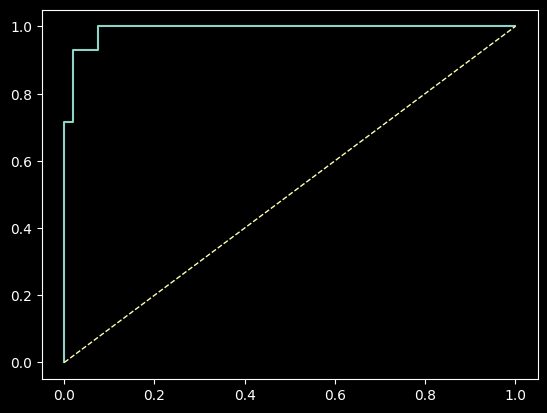

In [15]:
# Execução de etapa intermediária do processo.
fpr, tpr, thr = roc_curve_points(y_tst, Xs@w)


plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--',linewidth=1)